###  Installing Required Libraries

After installation, you will need to **restart the runtime**.


In [1]:
!pip install torchtext==0.16.0
!pip install portalocker>=2.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.1.0.70
    Uninstalling nvidia-cudnn-cu12-9.1.0.70:
      Successfully uninstalled nvi

# Part One: Implementing the Attention Module


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(d_model, d_k)
        self.key = nn.Linear(d_model, d_k)
        self.value = nn.Linear(d_model, d_v)
        self.scale = math.sqrt(d_k)

    def apply_mask(self, attn_output, mask):
        return attn_output * mask

    def forward(self, x, mask=None):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = self.apply_mask(scores, mask)

        attention_weights = F.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, V)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.h = h
        self.attention_heads = nn.ModuleList([SelfAttention(d_model, d_k, d_v) for _ in range(h)])
        self.linear = nn.Linear(h * d_v, d_model)

    def forward(self, x, mask=None):
        head_outputs = []
        head_outputs = [head(x, mask) for head in self.attention_heads]
        concat_heads = torch.cat(head_outputs, dim=-1)
        output = self.linear(concat_heads)

        return output

d = 512
h = 8
d_k = d // h
d_v = d // h
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)
multi_head_attn = MultiHeadAttention(d_model=d, h=h, d_k=d_k, d_v=d_v)
output = multi_head_attn(x)
print(output.shape)  # expected: (64, 10, 512)

torch.Size([64, 10, 512])


# Part Two: Implementing the Feed Forward Module











In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        out = self.layer_norm(self.linear2(self.relu(self.linear1(x))))
        return out

d = 512
d_ff = 2048
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)
ff = FeedForward(d_model=d, d_ff=d_ff)
output = ff(x)
print(output.shape)  # expected: (64, 10, 512)

torch.Size([64, 10, 512])


# Part Three: Implementing the Encoder











In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(EncoderLayer, self).__init__()
        d_k = d_model // h
        d_v = d_model // h
        self.self_attention = MultiHeadAttention(d_model, h, d_k, d_v)
        self.attention_norm = nn.LayerNorm(d_model)

        self.feed_forward = FeedForward(d_model, d_ff)
        self.feed_forward_nrom = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Multi-Head Attention + Add & Norm
        out = self.self_attention(x, mask)
        x = self.attention_norm(out + x)
        out = self.feed_forward(x)
        x = self.feed_forward_nrom(out + x)
        return x

class Encoder(nn.Module):
    def __init__(self, N_e, d_model, h, d_ff):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff) for _ in range(N_e)])
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        #TODO: Implement the forward pass of the encoder
        for layer in self.layers:
            x = layer(x, mask)
        x = self.layer_norm(x)
        return x

N_e = 6
d = 512
h = 8
d_ff = 2048
batch_size = 64
seq_len = 10

x = torch.randn(batch_size, seq_len, d)
encoder = Encoder(N_e=N_e, d_model=d, h=h, d_ff=d_ff)
output = encoder(x)
print(output.shape)  # expected: (64, 10, 512)

torch.Size([64, 10, 512])


# Part Four: Implementing the Decoder










In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff):
        super(DecoderLayer, self).__init__()
        #TODO: Define the layers needed for the decoder layer
        d_k = d_model // h
        d_v = d_model // h
        self.self_attention = MultiHeadAttention(d_model, h, d_k, d_v)
        self.attention_norm = nn.LayerNorm(d_model)

        self.cross_attention = MultiHeadAttention(d_model, h, d_k, d_v)
        self.cross_attention_norm = nn.LayerNorm(d_model)

        self.feed_forward = FeedForward(d_model, d_ff)
        self.feed_forward_norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        #TODO: Implement the forward pass of the decoder layer
        # Self-Attention with masking + Add & Norm
        attn_output = self.self_attention(x, mask=tgt_mask)
        x = self.attention_norm(attn_output + x)

        # Cross-Attention + Add & Norm
        cross_attn_out = self.cross_attention(encoder_output, mask=src_mask)
        if cross_attn_out.shape[1] > x.shape[1]:
            padding = cross_attn_out.shape[1] - x.shape[1]
            x = torch.nn.functional.pad(x, (0, 0, 0, padding))
        x = self.cross_attention_norm(cross_attn_out + x)

        # Feed Forward + Add & Norm
        ff_out = self.feed_forward(x)
        x = self.feed_forward_norm(ff_out + x)
        return x

class Decoder(nn.Module):
    def __init__(self, N_d, d_model, h, d_ff):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff) for _ in range(N_d)])
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        #TODO: Implement the forward pass of the decoder
        for layer in self.layers:
            x = layer(x, encoder_output, tgt_mask, src_mask)
        return self.layer_norm(x)
        return x

N_d = 6
d = 512
h = 8
d_ff = 2048
batch_size = 64
tgt_seq_len = 10
src_seq_len = 10

x = torch.randn(batch_size, tgt_seq_len, d)
encoder_output = torch.randn(batch_size, src_seq_len, d)
decoder = Decoder(N_d=N_d, d_model=d, h=h, d_ff=d_ff)
output = decoder(x, encoder_output)
print(output.shape)  # expected: (64, 10, 512)

torch.Size([64, 10, 512])


# Implementing Embedding, Positional Encoding



In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        #TODO: Implement the positional encoding
        self.pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class EmbeddingWithPositionalEncoding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000):
        super(EmbeddingWithPositionalEncoding, self).__init__()
        #TODO: Implement the embedding layer with positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x = self.pos_encoding(x)
        return x

vocab_size = 10000
d = 512
max_len = 100
batch_size = 64
seq_len = 20

x = torch.randint(0, vocab_size, (batch_size, seq_len))
embedding_pe = EmbeddingWithPositionalEncoding(vocab_size=vocab_size, d_model=d, max_len=max_len)
output = embedding_pe(x)
print(output.shape)  # expected: (64, 20, 512)

torch.Size([64, 20, 512])


# Part Six: Designing the Overall Model Architecture











In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, N_e, N_d, d_model, h, d_ff, max_len):
        super(TransformerModel, self).__init__()
        # Define encoder, decoder, and other components here
        self.encoder = Encoder(N_e=N_e, d_model=d_model, h=h, d_ff=d_ff)
        self.decoder = Decoder(N_d=N_d, d_model=d_model, h=h, d_ff=d_ff)
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.positional_encoding = PositionalEncoding(d_model=d_model, max_len=max_len)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # src: (batch_size, src_seq_len)
        src_embed = self.src_embedding(src)
        src_embed = self.positional_encoding(src_embed)
        enc_out = self.encoder(src_embed)

        # tgt: (batch_size, tgt_seq_len)
        tgt_embed = self.tgt_embedding(tgt)
        tgt_embed = self.positional_encoding(tgt_embed)
        dec_out = self.decoder(tgt_embed, enc_out)

        #TODO: Define Forward pass of Transformer model
        output = self.fc_out(dec_out)
        return output  # (batch_size, tgt_seq_len, tgt_vocab_size)

src_vocab_size = 10000
tgt_vocab_size = 10000
N_e = 6
N_d = 6
d_model = 512
h = 8
d_ff = 2048
max_len = 100
batch_size = 64
src_seq_len = 20
tgt_seq_len = 20

src = torch.randint(0, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(0, tgt_vocab_size, (batch_size, tgt_seq_len))

model = TransformerModel(src_vocab_size=src_vocab_size,
                        tgt_vocab_size=tgt_vocab_size,
                        N_e=N_e,
                        N_d=N_d,
                        d_model=d_model,
                        h=h,
                        d_ff=d_ff,
                        max_len=max_len)

output = model(src, tgt)
print(output.shape)  # expected: (64, 20, 10000)

torch.Size([64, 20, 10000])


# Part Seven: Training and Evaluating the Model with Prepared Data











## Loading the required library for the English-German dataset










In [8]:
torch.cuda.is_available()

True

In [9]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 97.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Loading data and libraries, and preparing the dataset











In [27]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import multi30k, Multi30k

# Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Update URLs to point to data stored by user
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"
multi30k.URL["test"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/mmt_task1_test2016.tar.gz"

# Update hash since there is a discrepancy between user hosted test split and that of the test split in the original dataset
multi30k.MD5["test"] = "876a95a689a2a20b243666951149fd42d9bfd57cbbf8cd2c79d3465451564dd2"

test = Multi30k(split='test', language_pair=('en', 'de'))
train = Multi30k(split='train', language_pair=('en', 'de'))
valid = Multi30k(split='valid', language_pair=('en', 'de'))

# Step 3: Load dataset
train_iter = to_map_style_dataset(train)[:2000]
valid_iter = to_map_style_dataset(valid)[:2000]
test_iter = to_map_style_dataset(test)
print("Datasets loaded successfully.")

# Load spaCy models
spacy_eng = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

# Tokenizers using spaCy
def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

# Build vocabulary from training dataset
def yield_tokens(data_iter, tokenizer):
    for src, tgt in data_iter:
        yield tokenizer(src)
        yield tokenizer(tgt)

SRC_TOKENIZER = tokenize_en
TGT_TOKENIZER = tokenize_de

SRC_VOCAB = build_vocab_from_iterator(yield_tokens(train_iter, SRC_TOKENIZER), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'])
SRC_VOCAB.set_default_index(SRC_VOCAB['<UNK>'])

TGT_VOCAB = build_vocab_from_iterator(yield_tokens(train_iter, TGT_TOKENIZER), specials=['<PAD>', '<UNK>', '<BOS>', '<EOS>'])
TGT_VOCAB.set_default_index(TGT_VOCAB['<UNK>'])

# Parameters
max_len = 50
batch_size = 128
num_epochs = 5
learning_rate = 0.0001

# Define Dataset
class TranslationDataset(Dataset):
    def __init__(self, data_iter, src_vocab, tgt_vocab, src_tokenizer, tgt_tokenizer, max_len):
        self.data = list(data_iter)
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_tokens = self.src_tokenizer(src)
        tgt_tokens = self.tgt_tokenizer(tgt)

        # Add <BOS> and <EOS>
        src_tokens = ['<BOS>'] + src_tokens + ['<EOS>']
        tgt_tokens = ['<BOS>'] + tgt_tokens + ['<EOS>']

        # Truncate or pad
        src_tokens = src_tokens[:self.max_len] + ['<PAD>'] * max(0, self.max_len - len(src_tokens))
        tgt_tokens = tgt_tokens[:self.max_len] + ['<PAD>'] * max(0, self.max_len - len(tgt_tokens))

        # Convert to indices
        src_indices = [self.src_vocab[token] for token in src_tokens]
        tgt_indices = [self.tgt_vocab[token] for token in tgt_tokens]

        return torch.LongTensor(src_indices), torch.LongTensor(tgt_indices)


Using device: cuda
Datasets loaded successfully.


In [28]:
# Define Datasets
train_dataset = TranslationDataset(train_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)
valid_dataset = TranslationDataset(valid_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)
test_dataset = TranslationDataset(test_iter, SRC_VOCAB, TGT_VOCAB, SRC_TOKENIZER, TGT_TOKENIZER, max_len)

# Define DataLoaders with pin_memory for faster GPU transfer
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

## Define the Transformer model

* Ensure you have defined the TransformerModel class appropriately

* Example placeholder (replace with your actual model definition)

In [29]:
print(next(iter(train_loader))[0].shape)
print(next(iter(valid_loader))[0].shape)

torch.Size([128, 50])
torch.Size([128, 50])


In [30]:
print(len(train_dataset))

2000


## Defining the model using a pre-written class, training the model, and displaying the performance chart during training











In [ ]:
# Initialize model and move to device
tgt_vocab_size = len(TGT_VOCAB)
src_vocab_size = len(SRC_VOCAB)

print(src_vocab_size)
print(tgt_vocab_size)
N_e = 6
N_d = 6
L = max_len
d = 512
h = 8
d_ff = 2048

model = TransformerModel(src_vocab_size=src_vocab_size,
                         tgt_vocab_size=tgt_vocab_size,
                         N_e=N_e,
                         N_d=N_d,
                         d_model=d,
                         h=h,
                         d_ff=d_ff,
                         max_len=L).to(device)  # Move model to GPU

# TODO:Define loss function and optimizer
#criterion (Loss function)
criterion = nn.CrossEntropyLoss()

#optimizer (Optimizer)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
loss_values = []

5931
6028


batch size = 128, train-data-length = 2000

In [32]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for src_batch, tgt_batch in train_loader:
        # Move data to device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()

        # Inputs and targets
        src = src_batch.long()  # (batch, src_seq_len)
        tgt = tgt_batch.long()

        tgt_input = tgt_batch[:, :-1]  # (batch, tgt_seq_len -1)
        tgt_output = tgt_batch[:, 1:]  # (batch, tgt_seq_len -1)

        # TODO: Forward pass
        output = model(src, tgt_input)

        if output.shape[1] > tgt_output.shape[1]:
            padding = output.shape[1] - tgt_output.shape[1]
            tgt_output = torch.nn.functional.pad(tgt_output, (0, padding))

        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        # TODO: Compute loss
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch Loss: {epoch_loss:.4f}")

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch Loss: 8.6887
Epoch Loss: 12.2946
Epoch Loss: 15.2946
Epoch Loss: 18.2025
Epoch Loss: 21.0212
Epoch Loss: 23.8671
Epoch Loss: 26.6483
Epoch Loss: 29.3825
Epoch Loss: 31.9319
Epoch Loss: 34.4233
Epoch Loss: 36.8878
Epoch Loss: 39.2792
Epoch Loss: 41.5440
Epoch Loss: 43.8440
Epoch Loss: 46.0324
Epoch Loss: 48.0603
Epoch 1/5, Loss: 3.0038
Epoch Loss: 2.0482
Epoch Loss: 4.0391
Epoch Loss: 5.9406
Epoch Loss: 7.8327
Epoch Loss: 9.6099
Epoch Loss: 11.3838
Epoch Loss: 13.2187
Epoch Loss: 14.9191
Epoch Loss: 16.6786
Epoch Loss: 18.4620
Epoch Loss: 20.2533
Epoch Loss: 21.9822
Epoch Loss: 23.7292
Epoch Loss: 25.3860
Epoch Loss: 27.0131
Epoch Loss: 28.6732
Epoch 2/5, Loss: 1.7921
Epoch Loss: 1.5624
Epoch Loss: 3.1070
Epoch Loss: 4.6346
Epoch Loss: 6.1921
Epoch Loss: 7.6930
Epoch Loss: 9.2370
Epoch Loss: 10.7968
Epoch Loss: 12.2965
Epoch Loss: 13.8000
Epoch Loss: 15.2916
Epoch Loss: 16.7307
Epoch Loss: 18.2434
Epoch Loss: 19.6621
Epoch Loss: 21.1581
Epoch Loss: 22.6405
Epoch Loss: 24.0653
Epoc

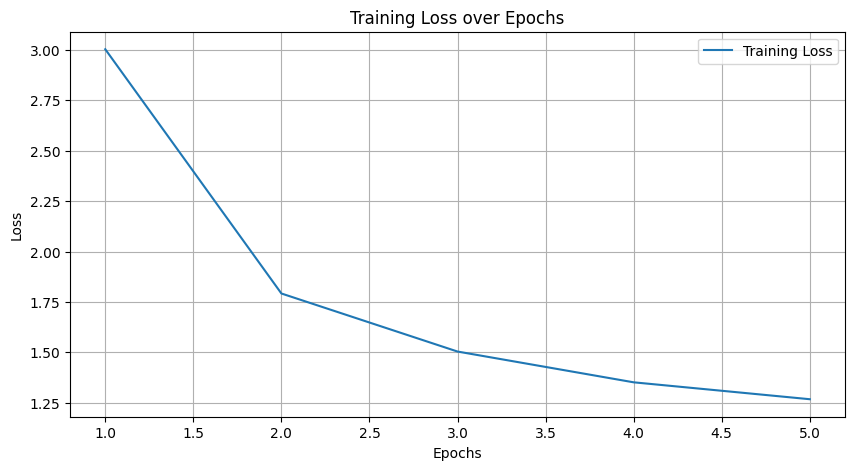

In [33]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

batch size = 32, train-data-length = 1000

In [16]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for src_batch, tgt_batch in train_loader:
        # Move data to device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()

        # Inputs and targets
        src = src_batch.long()  # (batch, src_seq_len)
        tgt = tgt_batch.long()

        tgt_input = tgt_batch[:, :-1]  # (batch, tgt_seq_len -1)
        tgt_output = tgt_batch[:, 1:]  # (batch, tgt_seq_len -1)

        # TODO: Forward pass
        output = model(src, tgt_input)

        if output.shape[1] > tgt_output.shape[1]:
            padding = output.shape[1] - tgt_output.shape[1]
            tgt_output = torch.nn.functional.pad(tgt_output, (0, padding))

        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        # TODO: Compute loss
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch Loss: {epoch_loss:.4f}")

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch Loss: 8.2870
Epoch Loss: 12.2457
Epoch Loss: 15.2994
Epoch Loss: 18.2696
Epoch Loss: 20.8730
Epoch Loss: 23.4539
Epoch Loss: 26.0275
Epoch Loss: 28.3730
Epoch Loss: 31.0168
Epoch Loss: 33.3090
Epoch Loss: 35.3954
Epoch Loss: 37.4379
Epoch Loss: 39.3929
Epoch Loss: 41.2656
Epoch Loss: 43.1125
Epoch Loss: 44.9211
Epoch Loss: 46.6113
Epoch Loss: 48.4226
Epoch Loss: 50.4686
Epoch Loss: 52.1785
Epoch Loss: 53.9118
Epoch Loss: 55.6583
Epoch Loss: 57.2539
Epoch Loss: 58.9494
Epoch Loss: 60.5608
Epoch Loss: 62.2182
Epoch Loss: 63.8722
Epoch Loss: 65.4289
Epoch Loss: 67.0279
Epoch Loss: 68.7637
Epoch Loss: 70.2803
Epoch Loss: 71.6940
Epoch 1/5, Loss: 2.2404
Epoch Loss: 1.4946
Epoch Loss: 2.8645
Epoch Loss: 4.3231
Epoch Loss: 6.1089
Epoch Loss: 7.6625
Epoch Loss: 9.2562
Epoch Loss: 10.6972
Epoch Loss: 12.1094
Epoch Loss: 13.5707
Epoch Loss: 14.8366
Epoch Loss: 16.3376
Epoch Loss: 17.8368
Epoch Loss: 19.1506
Epoch Loss: 20.8034
Epoch Loss: 22.2616
Epoch Loss: 23.7356
Epoch Loss: 25.0678
Epo

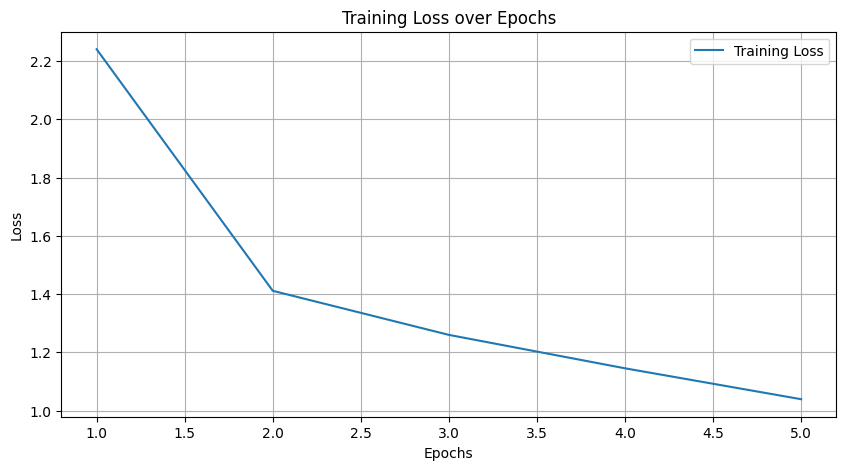

In [18]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

batch size = 4, train-data-length = 200

In [25]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for src_batch, tgt_batch in train_loader:
        # Move data to device
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()

        # Inputs and targets
        src = src_batch.long()  # (batch, src_seq_len)
        tgt = tgt_batch.long()

        tgt_input = tgt_batch[:, :-1]  # (batch, tgt_seq_len -1)
        tgt_output = tgt_batch[:, 1:]  # (batch, tgt_seq_len -1)

        # TODO: Forward pass
        output = model(src, tgt_input)

        if output.shape[1] > tgt_output.shape[1]:
            padding = output.shape[1] - tgt_output.shape[1]
            tgt_output = torch.nn.functional.pad(tgt_output, (0, padding))

        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.contiguous().view(-1)

        # TODO: Compute loss
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Epoch Loss: {epoch_loss:.4f}")

    avg_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch Loss: 1.1627
Epoch Loss: 2.8396
Epoch Loss: 3.8786
Epoch Loss: 5.1386
Epoch Loss: 6.1183
Epoch Loss: 7.4789
Epoch Loss: 8.4866
Epoch Loss: 9.4647
Epoch Loss: 10.6394
Epoch Loss: 11.9780
Epoch Loss: 13.7256
Epoch Loss: 15.1485
Epoch Loss: 16.1337
Epoch Loss: 17.6427
Epoch Loss: 18.4917
Epoch Loss: 20.7402
Epoch Loss: 21.8545
Epoch Loss: 23.3602
Epoch Loss: 24.5252
Epoch Loss: 25.9934
Epoch Loss: 27.1805
Epoch Loss: 28.4598
Epoch Loss: 29.8338
Epoch Loss: 31.1593
Epoch Loss: 32.4161
Epoch Loss: 34.0903
Epoch Loss: 35.0985
Epoch Loss: 36.6026
Epoch Loss: 37.4450
Epoch Loss: 38.4433
Epoch Loss: 39.6770
Epoch Loss: 40.7278
Epoch Loss: 42.1588
Epoch Loss: 43.5058
Epoch Loss: 44.7151
Epoch Loss: 46.3750
Epoch Loss: 48.0179
Epoch Loss: 49.4073
Epoch Loss: 50.4367
Epoch Loss: 51.4296
Epoch Loss: 52.8151
Epoch Loss: 53.7984
Epoch Loss: 55.4420
Epoch Loss: 57.3937
Epoch Loss: 58.4498
Epoch Loss: 59.9089
Epoch Loss: 61.3607
Epoch Loss: 62.4537
Epoch Loss: 63.8059
Epoch Loss: 64.8331
Epoch 1/

### TODO: Plotting the loss curve


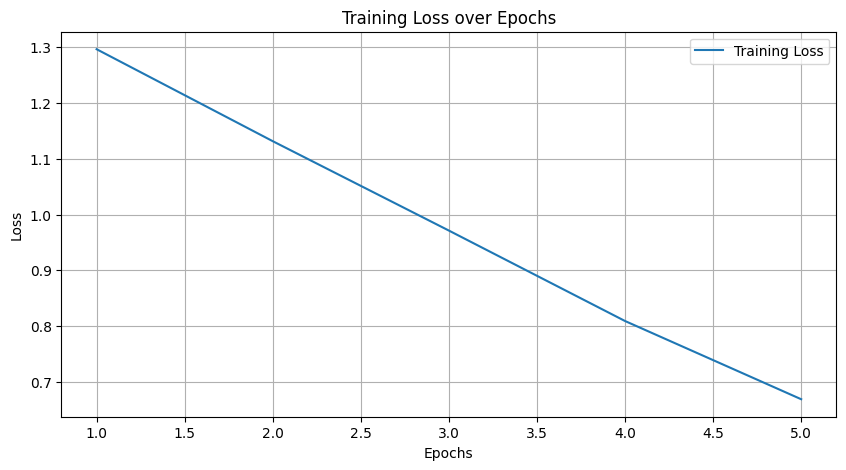

In [26]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Vocabulary size: {len(SRC_VOCAB)}")


Vocabulary size: 1400


In [ ]:
model.src_embedding.num_embeddings

3906